<a href="https://colab.research.google.com/github/andre-meneses/small-worlds/blob/main/Project_U2P1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **FEDERAL UNIVERSITY OF RIO GRANDE DO NORTE**
## **ALGORITHMS AND DATA STRUCTURES II**

### **Instructor:**

1. Ivanovitch Medeiros Dantas da Silva

### **Students:**

1. André Eduardo Meneses do Nascimento
2. Matheus Gomes Diniz Andrade

# Installing Libraries

In [ ]:
!pip install nxviz
!pip install scikit-learn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# Import Libraries

In [ ]:
import numpy    as np
import pandas   as pd
import networkx as nx

import matplotlib.pyplot    as plt
import seaborn              as sns
import plotly.graph_objects as go

import nxviz as nv
from nxviz import annotate, highlights
from sklearn.preprocessing import MinMaxScaler

# Notebook Patterns

In [ ]:
plot = {
  "size": (15, 6),
  "title_size": 20,
  "title_color": "#262626",
  "subtitle_size": 16,
  "subtitle_color": "#868586",
}

region_colors = {
  "NORTE": "#71B37B",
  "SUDESTE": "#F27A7A",
  "NORDESTE": "#FAAD41",
  "CENTRO-OESTE": "#D36DD5",
  "SUL": "#4DA9C4"
}

# Data Aquisition

In this project, we will be working with a dataset from the Brazilian aviation network, which can be found at the [Link](https://github.com/alvarofpp/dataset-flights-brazil/).

In [ ]:
!gdown "https://raw.githubusercontent.com/alvarofpp/dataset-flights-brazil/main/data/air_traffic.graphml"
!gdown "https://raw.githubusercontent.com/alvarofpp/dataset-flights-brazil/main/data/airports.csv"

Downloading...
From: https://raw.githubusercontent.com/alvarofpp/dataset-flights-brazil/main/data/air_traffic.graphml
To: /content/air_traffic.graphml
999kB [00:00, 26.2MB/s]        
Downloading...
From: https://raw.githubusercontent.com/alvarofpp/dataset-flights-brazil/main/data/airports.csv
To: /content/airports.csv
87.6kB [00:00, 53.2MB/s]       


In [ ]:
file_path_graphml = "air_traffic.graphml"
file_path_csv     = "airports.csv"

In [ ]:
airports_graph   = nx.read_graphml(file_path_graphml)
airports_dataset = pd.read_csv(file_path_csv)

## Data Preprocessing

As we are only interested in domestic flights, let's remove data involving flights with `country` different of `BRASIL`.

In [ ]:
brazilian_flights_nodes = [node for node, data in airports_graph.nodes(data=True) if data.get("country") == "BRASIL"]
brazilian_flights_graph = airports_graph.subgraph(brazilian_flights_nodes)

brazilian_flights_dataset = airports_dataset.query("country == 'BRASIL'").reset_index(drop=True)

Now, we create attributes `region` and `code` for the brazilian airports nodes.

In [ ]:
for node, data in brazilian_flights_graph.nodes(data=True):
  for idx, row in brazilian_flights_dataset.iterrows():
    if data["name"] == row["name"]:
      data["region"] = row["region"]
      data["code"]   = row["code"]

      break

In [ ]:
def compute_distance(node1, node2):
  EARTH_RADIUS = 6371.0

  node1_lat, node1_lon = float(node1["latitude"]), float(node1["longitude"])
  node2_lat, node2_lon = float(node2["latitude"]), float(node2["longitude"])

  lat_dist = node2_lat - node1_lat
  lon_dist = node2_lon - node1_lon

  a = np.sin(lat_dist / 2) ** 2 + np.cos(node1_lat) * np.cos(node2_lat) * np.sin(lon_dist / 2) ** 2
  c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))

  dist = EARTH_RADIUS * c

  return dist

In [ ]:
for node1, node2, data in brazilian_flights_graph.edges(data=True):
  node1 = brazilian_flights_graph.nodes[node1]
  node2 = brazilian_flights_graph.nodes[node2]

  data["distance"] = compute_distance(node1, node2)

Removing nodes from brazilian flights if they have a degree less than 1

In [ ]:
brazilian_flights_graph_unfrozen = nx.Graph(brazilian_flights_graph)

nodes_to_remove = [node for node in brazilian_flights_graph_unfrozen.nodes if brazilian_flights_graph_unfrozen.degree(node) < 1]

brazilian_flights_graph_unfrozen.remove_nodes_from(nodes_to_remove)

brazilian_flights_graph = brazilian_flights_graph_unfrozen

# Exploratory Analysis

Number of nodes and edges in the network

In [ ]:
N = brazilian_flights_graph.number_of_nodes()
L = brazilian_flights_graph.number_of_edges()

print("Number of nodes:", N)
print("Number of edges:", L)

Number of nodes: 491
Number of edges: 4402


## Graph Network Metrics

### Density

This graph network is **undirected**. We can compute the **density** by:

$d(G) = \frac{2 \cdot L}{N \cdot (N - 1)} = \frac{2 \cdot 4402}{495 \cdot (495 - 1)}$

In [ ]:
density = (2 * L) / (N * (N - 1))

print(f"Density: {round(density * 100, 2)}%")

Density: 3.66%


It's not a dense graph network

### Clustering Coefficient


The clustering coefficient ranges from 0 to 1, with 0 indicating no clustering and 1 indicating that all the neighbors of a node are connected to each other.



In [ ]:
nx.average_clustering(brazilian_flights_graph)

0.6281265705036321

On average, the nodes in this graph have a relatively high tendency to form well-connected clusters or groups.

## Dataset Metrics

In [ ]:
bar_values = dict(brazilian_flights_dataset["region"].value_counts())

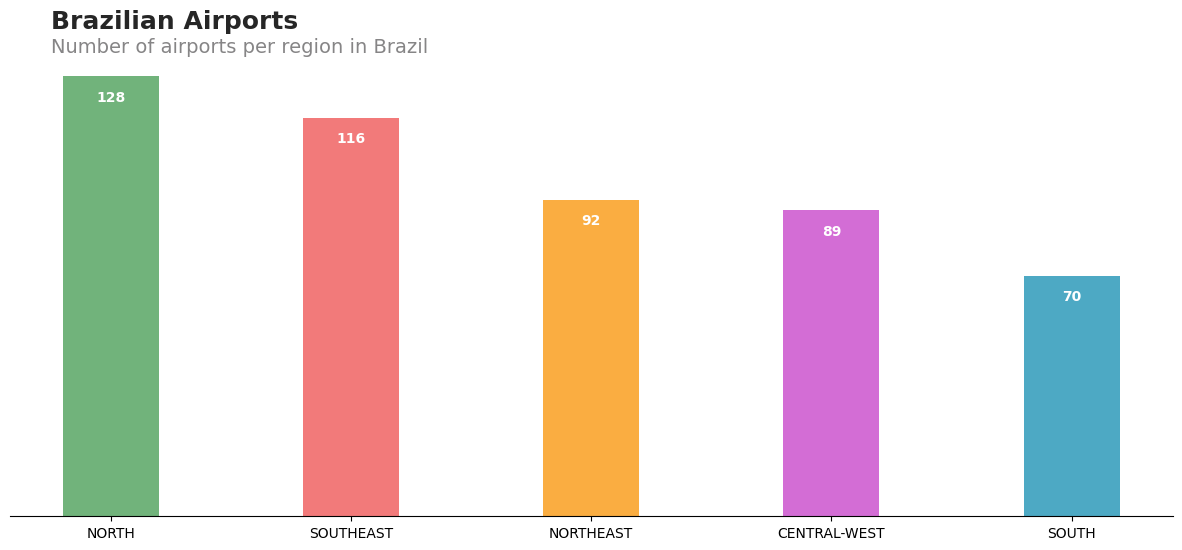

In [ ]:
fig, ax = plt.subplots(figsize=plot["size"])

ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
ax.spines["left"].set_visible(False)

bars = ax.bar(
  list(bar_values.keys()),
  list(bar_values.values()),
  width=0.4,
  color=list(region_colors.values())
)

ax.set_yticks([])
ax.set_xticks(
  ["NORTE", "SUDESTE", "NORDESTE", "CENTRO-OESTE", "SUL"],
  ["NORTH", "SOUTHEAST", "NORTHEAST", "CENTRAL-WEST", "SOUTH"]
)

for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width() / 2, height - 8, str(int(height)), ha='center', va='bottom', color="#ffffff", weight="bold")

plt.text(-0.25, 142, "Brazilian Airports", fontsize=18, color=plot["title_color"], weight="bold")
plt.text(-0.25, 135, "Number of airports per region in Brazil", fontsize=14, color=plot["subtitle_color"])

plt.show()

# Assortativity

Assortativity is a metric that describes the tendency of similar nodes be connected.

- Assortativity $\rightarrow$ 1:

  **Assortative network**. In this case, nodes with similar degrees have a tendency to connect withtrad each other.

- Assortativity $\rightarrow$ 0:

  **Neutral network**. In this case, nodes don't have preference to connect.

- Assortativity $\rightarrow$ -1:

  **Disassortative network**. In this case, nodes with different degrees have a tendency to connect withtrad each other.
  

## By Node Degree

In [ ]:
nx.degree_assortativity_coefficient(brazilian_flights_graph)

-0.20170971729797435

## By Clustering Coefficient

In [ ]:
for node, data in brazilian_flights_graph.nodes(data=True):
  data["clustering_coef"] = nx.clustering(brazilian_flights_graph, node)

In [ ]:
nx.attribute_assortativity_coefficient(brazilian_flights_graph, "clustering_coef")

-0.007288525641192707

## By Brazilian Region

In [ ]:
nx.attribute_assortativity_coefficient(brazilian_flights_graph, "region")

0.3673097651139229

When considering the network involving airports in Brazil, assortativity yielded a negative value, indicating a tendency for airports with higher degrees of connections to connect with airports with lower degrees, and vice versa.

However, when considering the network of Brazilian airports based on their geographical region, assortativity yielded a positive value. This implies that there is a tendency for airports with higher degrees of connections to connect with other airports of high degree within the same region.

### Interactive Plot

In [ ]:
# Normalize edge weights using min-max scaling
edge_weights = [data['flight_count'] for _, _, data in brazilian_flights_graph.edges(data=True)]
scaler = MinMaxScaler()
normalized_weights = scaler.fit_transform([[w] for w in edge_weights])

# Extract node attributes
positions = {node: (data['longitude'], data['latitude']) for node, data in brazilian_flights_graph.nodes(data=True)}
regions = nx.get_node_attributes(brazilian_flights_graph, 'region')

edge_traces = []
for i, edge in enumerate(brazilian_flights_graph.edges(data=True)):
    x0, y0 = positions[edge[0]]
    x1, y1 = positions[edge[1]]
    flight_counts = normalized_weights[i][0]
    edge_trace = go.Scattergeo(
        locationmode='country names',
        lon=[x0, x1],
        lat=[y0, y1],
        mode='lines',
        line=dict(width=flight_counts, color='black'),
    )
    edge_traces.append(edge_trace)

node_trace = go.Scattergeo(
    locationmode='country names',
    lon=[data['longitude'] for node, data in brazilian_flights_graph.nodes(data=True)],
    lat=[data['latitude'] for node, data in brazilian_flights_graph.nodes(data=True)],
    text=[data['name'] for node, data in brazilian_flights_graph.nodes(data=True)],
    mode='markers',
    marker=dict(
        size=8,
        color=[region_colors[regions[node]] for node in brazilian_flights_graph.nodes()],
        colorscale='Viridis',
        colorbar=dict(title='Region'),
        opacity=0.8,
    ),
)

fig = go.Figure(data=edge_traces + [node_trace])
fig.update_layout(
    title='Interactive Graph - Brazil',
    showlegend=False,
    geo=dict(showland=False, showcoastlines=True),
    margin=dict(l=0, r=0, t=30, b=30)
)
fig.show()


Some of the nodes appears to have wrong coordinates, as their regions are mismatched. 

**Ploting the whole network, internacional flights included**

In [ ]:
# Normalize edge weights using min-max scaling
edge_weights = [data['flight_count'] for _, _, data in airports_graph.edges(data=True)]
scaler = MinMaxScaler()
normalized_weights = scaler.fit_transform([[w] for w in edge_weights])

# Extract node attributes
positions = {node: (data['longitude'], data['latitude']) for node, data in airports_graph.nodes(data=True)}

edge_traces = []
for i, edge in enumerate(airports_graph.edges(data=True)):
    x0, y0 = positions[edge[0]]
    x1, y1 = positions[edge[1]]
    flight_counts = normalized_weights[i][0]
    edge_trace = go.Scattergeo(
        locationmode='country names',
        lon=[x0, x1],
        lat=[y0, y1],
        mode='lines',
        line=dict(width=flight_counts, color='black'),
    )
    edge_traces.append(edge_trace)

node_trace = go.Scattergeo(
    locationmode='country names',
    lon=[data['longitude'] for node, data in airports_graph.nodes(data=True)],
    lat=[data['latitude'] for node, data in airports_graph.nodes(data=True)],
    text=[data['name'] for node, data in airports_graph.nodes(data=True)],
    mode='markers',
    marker=dict(
        size=8,
        colorscale='Viridis',
        colorbar=dict(title='Region'),
        opacity=0.8,
    ),
)

fig = go.Figure(data=edge_traces + [node_trace])
fig.update_layout(
    title='Interactive Graph - Flight Network',
    showlegend=False,
    geo=dict(showland=False, showcoastlines=True),
    margin=dict(l=0, r=0, t=30, b=30)
)
fig.show()

### Static Plot

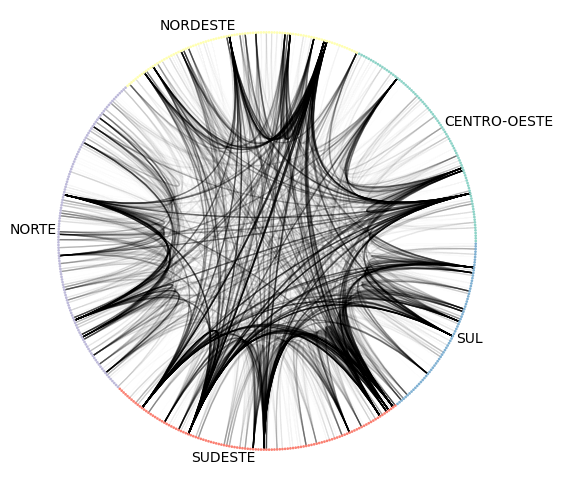

In [ ]:
fig, ax = plt.subplots(figsize=plot["size"])

ax = nv.circos(
  brazilian_flights_graph,
  group_by="region",
  node_color_by="region",
  edge_alpha_by="flight_count"
)

annotate.circos_group(brazilian_flights_graph, group_by="region")

# Display graph
plt.show()

# Bivariate Analysis

In [ ]:
network_degrees = pd.DataFrame()

In [ ]:
for node_info in zip(list(brazilian_flights_graph.nodes), dict(nx.degree(brazilian_flights_graph)).values(), nx.average_neighbor_degree(brazilian_flights_graph).values()):
  new_line = pd.DataFrame({
    "Self Degree": node_info[1],
    "Mean Neigh Degree": np.round(node_info[2], 2)
  }, index=[node_info[0]])

  network_degrees = pd.concat([
    network_degrees,
    new_line
  ])

In [ ]:
for idx, row in network_degrees.iterrows():
  network_degrees.loc[idx, "region"] = brazilian_flights_graph.nodes[idx]["region"]

In [ ]:
network_degrees.head()

Self Degree  Mean Neigh Degree        region
SNRU           10               88.8      NORDESTE
SDMC            5               81.2       SUDESTE
SWXM            4               56.0  CENTRO-OESTE
SWWU            1              132.0  CENTRO-OESTE
SNBU            1              130.0      NORDESTE

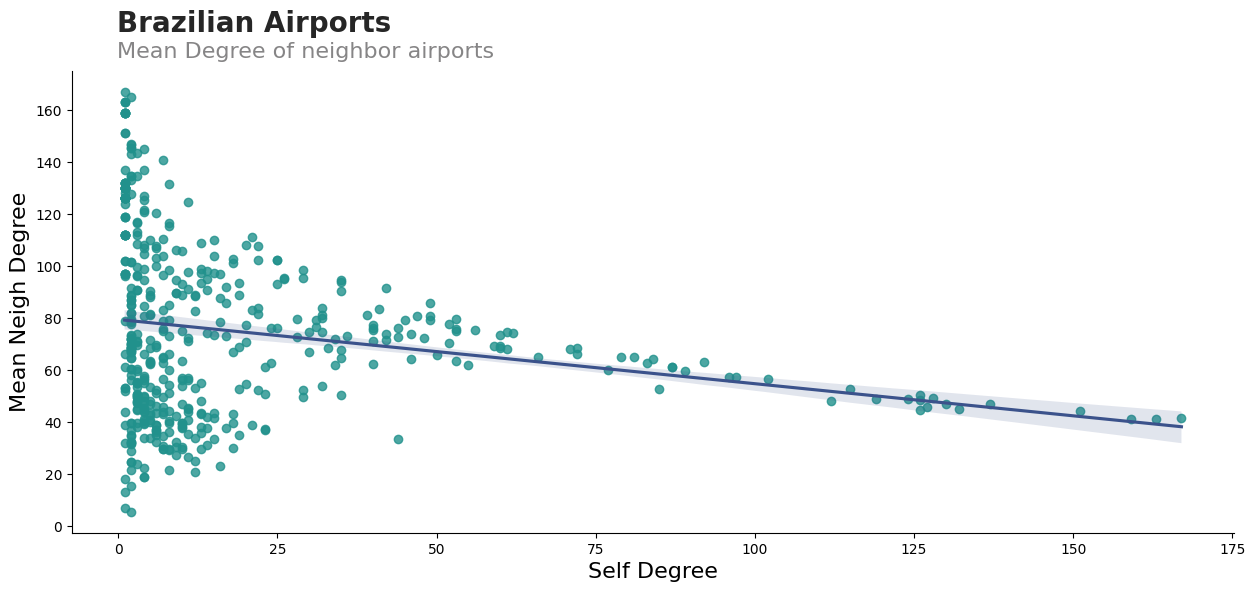

In [ ]:
fig, ax = plt.subplots(figsize=plot["size"])

ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)

ax = sns.regplot(
  data=network_degrees, x="Self Degree", y="Mean Neigh Degree",
  scatter_kws={"color": "#21918c"}, line_kws={"color": "#3b528b"}
)

ax.set_xlabel("Self Degree", fontsize=16)
ax.set_ylabel("Mean Neigh Degree", fontsize=16)
plt.text(-0.25, 190, "Brazilian Airports", fontsize=20, color=plot["title_color"], weight="bold")
plt.text(-0.25, 180, "Mean Degree of neighbor airports", fontsize=16, color=plot["subtitle_color"])

plt.show()

## By region

### North

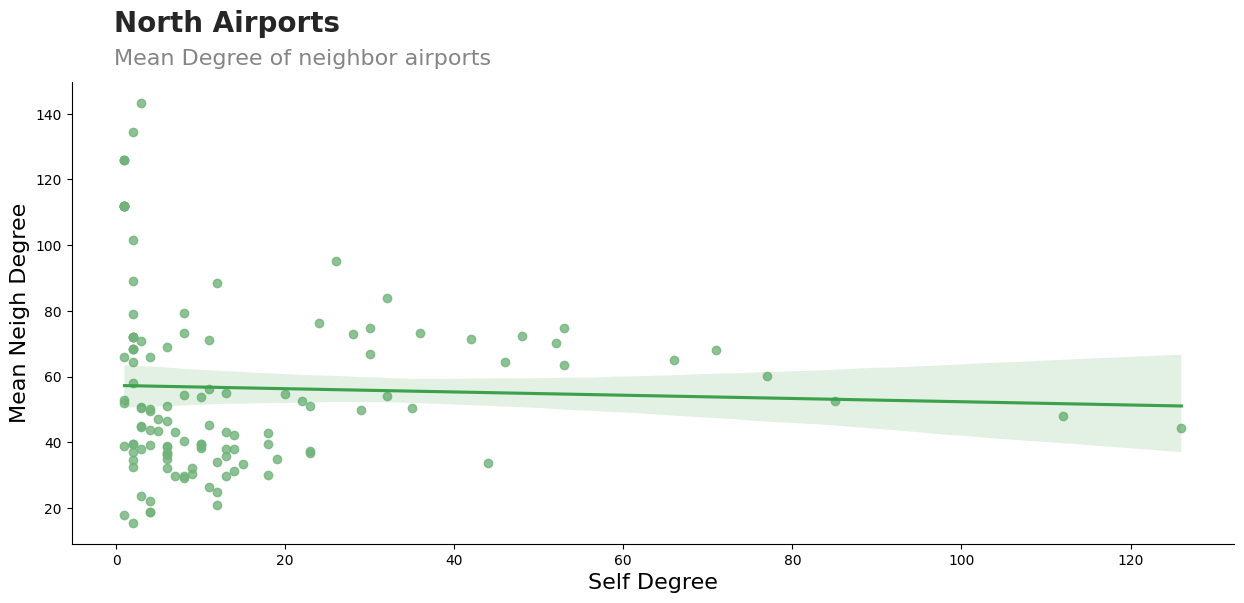

In [ ]:
fig, ax = plt.subplots(figsize=plot["size"])

ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)

ax = sns.regplot(
  data=network_degrees.query("region == 'NORTE'"), x="Self Degree", y="Mean Neigh Degree",
  scatter_kws={"color": region_colors["NORTE"]}, line_kws={"color": "#3DA14C"}
)

ax.set_xlabel("Self Degree", fontsize=16)
ax.set_ylabel("Mean Neigh Degree", fontsize=16)
plt.text(-0.25, 165, "North Airports", fontsize=20, color=plot["title_color"], weight="bold")
plt.text(-0.25, 155, "Mean Degree of neighbor airports", fontsize=16, color=plot["subtitle_color"])

plt.show()

### Northeast

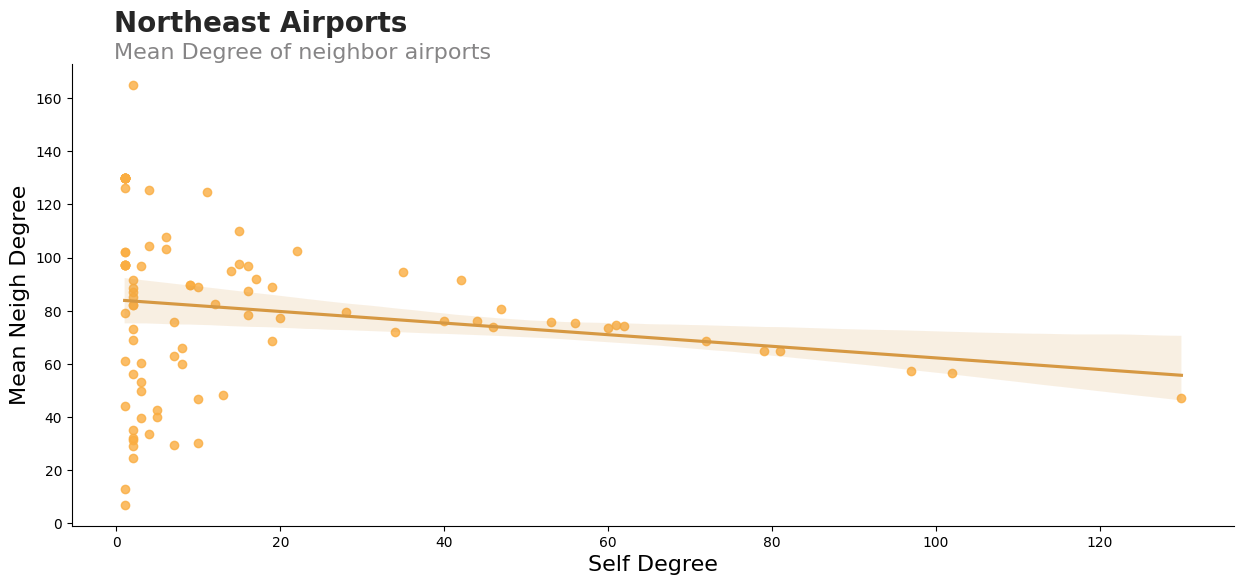

In [ ]:
fig, ax = plt.subplots(figsize=plot["size"])

ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)

ax = sns.regplot(
  data=network_degrees.query("region == 'NORDESTE'"), x="Self Degree", y="Mean Neigh Degree",
  scatter_kws={"color": region_colors["NORDESTE"]}, line_kws={"color": "#D69842"}
)

ax.set_xlabel("Self Degree", fontsize=16)
ax.set_ylabel("Mean Neigh Degree", fontsize=16)
plt.text(-0.25, 185, "Northeast Airports", fontsize=20, color=plot["title_color"], weight="bold")
plt.text(-0.25, 175, "Mean Degree of neighbor airports", fontsize=16, color=plot["subtitle_color"])

plt.show()

### Central-Wast

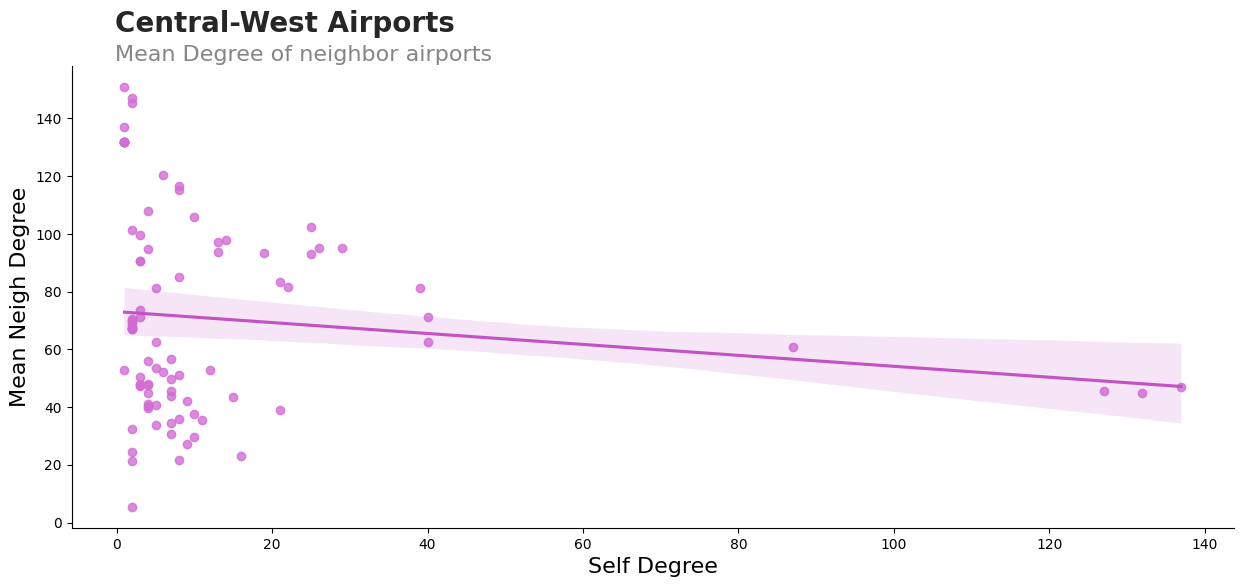

In [ ]:
fig, ax = plt.subplots(figsize=plot["size"])

ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)

ax = sns.regplot(
  data=network_degrees.query("region == 'CENTRO-OESTE'"), x="Self Degree", y="Mean Neigh Degree",
  scatter_kws={"color": region_colors["CENTRO-OESTE"]}, line_kws={"color": "#C153C3"}
)

ax.set_xlabel("Self Degree", fontsize=16)
ax.set_ylabel("Mean Neigh Degree", fontsize=16)
plt.text(-0.25, 170, "Central-West Airports", fontsize=20, color=plot["title_color"], weight="bold")
plt.text(-0.25, 160, "Mean Degree of neighbor airports", fontsize=16, color=plot["subtitle_color"])

plt.show()

### Southeast

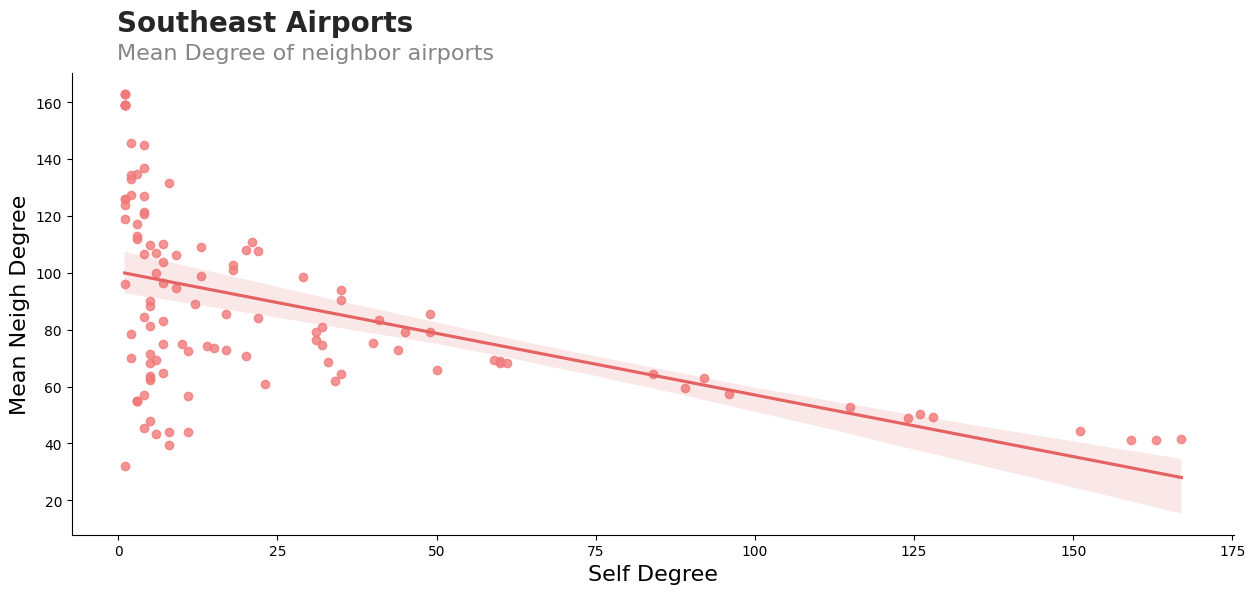

In [ ]:
fig, ax = plt.subplots(figsize=plot["size"])

ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)

ax = sns.regplot(
  data=network_degrees.query("region == 'SUDESTE'"), x="Self Degree", y="Mean Neigh Degree",
  scatter_kws={"color": region_colors["SUDESTE"]}, line_kws={"color": "#E46262"}
)

ax.set_xlabel("Self Degree", fontsize=16)
ax.set_ylabel("Mean Neigh Degree", fontsize=16)
plt.text(-0.25, 185, "Southeast Airports", fontsize=20, color=plot["title_color"], weight="bold")
plt.text(-0.25, 175, "Mean Degree of neighbor airports", fontsize=16, color=plot["subtitle_color"])

plt.show()

### South

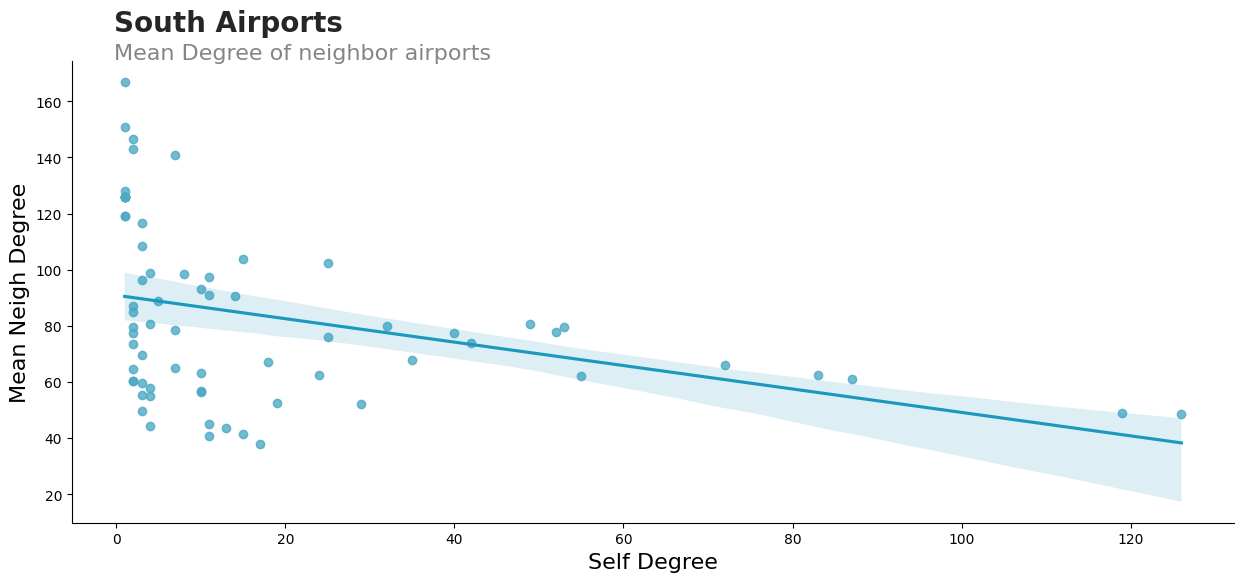

In [ ]:
fig, ax = plt.subplots(figsize=plot["size"])

ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)

ax = sns.regplot(
  data=network_degrees.query("region == 'SUL'"), x="Self Degree", y="Mean Neigh Degree",
  scatter_kws={"color": region_colors["SUL"]}, line_kws={"color": "#1B98BD"}
)

ax.set_xlabel("Self Degree", fontsize=16)
ax.set_ylabel("Mean Neigh Degree", fontsize=16)
plt.text(-0.25, 185, "South Airports", fontsize=20, color=plot["title_color"], weight="bold")
plt.text(-0.25, 175, "Mean Degree of neighbor airports", fontsize=16, color=plot["subtitle_color"])

plt.show()

# Connectivity

**Number of connected components - Brazil only network**

In [ ]:
nx.number_connected_components(brazilian_flights_graph)

1

**Analysing each connected component**





In [ ]:
connected_components = nx.connected_components(brazilian_flights_graph)

# Calculate the total number of nodes in the graph
total_nodes = len(brazilian_flights_graph.nodes)


# Iterate over the connected components and display the information
for i, component in enumerate(connected_components):
    component_nodes = list(component)
    component_size = len(component_nodes)
    percentage = (component_size / total_nodes) * 100
    print(f"Number of nodes: {component_size}")
    print(f"Percentage of total nodes: {percentage:.2f}%")
    print(f"First 5 nodes in the component: {component_nodes[:5]} \n \n")

Number of nodes: 491
Percentage of total nodes: 100.00%
First 5 nodes in the component: ['SNRU', 'SDMC', 'SWXM', 'SWWU', 'SNBU'] 
 



It follows that there are only 4 airports that are completely isolated from the brazilian network:

- SSBE: Campuã - MS
- SBER: Eirunepé - AM
- SNGR: Cumaru do Norte - PA
- SNBG: Baixo Guandú - ES

 **Number of connected components - Internacional and domestic flights**

In [ ]:
nx.number_connected_components(airports_graph)

3

- Connected components information - Whole network

In [ ]:
connected_components = nx.connected_components(airports_graph)

# Calculate the total number of nodes in the graph
total_nodes = len(airports_graph.nodes)


# Iterate over the connected components and display the information
for i, component in enumerate(connected_components):
    component_nodes = list(component)
    component_size = len(component_nodes)
    percentage = (component_size / total_nodes) * 100
    print(f"Number of nodes: {component_size}")
    print(f"Percentage of total nodes: {percentage:.2f}%")
    print(f"First 5 nodes in the component: {component_nodes[:5]} \n \n")

Number of nodes: 1080
Percentage of total nodes: 99.72%
First 5 nodes in the component: ['KOPF', 'SNRU', 'ZSNJ', 'SDMC', 'SANU'] 
 

Number of nodes: 1
Percentage of total nodes: 0.09%
First 5 nodes in the component: ['nan'] 
 

Number of nodes: 2
Percentage of total nodes: 0.18%
First 5 nodes in the component: ['FASU', 'SAOU'] 
 




When examining the entire network, encompassing both domestic and international flights, it becomes evident that nearly all airports are interconnected. However, there are two exceptions: the airports 'FASU' in South Africa and 'SAOU' in Argentina. These two airports are unique in that they only have connections among themselves, and do not link to any other airports in the network.

Nevertheless, the airports in Brazil that appear disconnected from the domestic network actually receive flights from foreign airports, which in turn have connections to other Brazilian airports. Consequently, these previously perceived isolated nodes are no longer disconnected when taking into account the entire network.

# Simulated Trip

In [ ]:
def trip(G, start_node, intermediate_regions):
  trip_list = [start_node]
  trip_step = 0
  distances = [0]

  for idx, region in enumerate(intermediate_regions):
    less_dist = 0
    less_node = None

    for node in brazilian_flights_graph.neighbors(trip_list[trip_step]):
      if brazilian_flights_graph.nodes[node]["region"] == intermediate_regions[trip_step]:
        if less_node == None:
          less_node, less_dist = node, brazilian_flights_graph.edges[(trip_list[trip_step], node)]["distance"]
        
        elif brazilian_flights_graph.edges[(trip_list[trip_step], node)]["distance"] < less_dist:
          less_node, less_dist = [node, brazilian_flights_graph.edges[(trip_list[trip_step], node)]["distance"]]
    
    trip_list.append(less_node)

    trip_step  += 1
    distances.append(less_dist)

  return distances, trip_list

In [ ]:
distances, trip_airports = trip(brazilian_flights_graph, "SBEG", ["SUL", "NORDESTE", "CENTRO-OESTE", "SUDESTE"])

In [ ]:
trip_data = pd.DataFrame()

In [ ]:
for node_code in trip_airports:
  trip_data = pd.concat([trip_data, pd.DataFrame(brazilian_flights_graph.nodes[node_code], index=[0])])

In [ ]:
trip_data = trip_data.reset_index(drop=True)[["name", "code", "latitude", "longitude", "region"]]
trip_data["distance"] = np.cumsum(distances)

trip_data

name  code             latitude           longitude        region  \
0         MANAUS  SBEG             -3.03861          -60.049702         NORTE   
1  FLORIANÓPOLIS  SBFL  -27.670278549194336   -48.5525016784668           SUL   
2      RIO LARGO  SBMO   -9.510809898376465  -35.79169845581055      NORDESTE   
3       BRASÍLIA  SBBR           -15.869167          -47.920834  CENTRO-OESTE   
4     SÃO CARLOS  SDZC           -21.875401          -47.903703       SUDESTE   

       distance  
0      0.000000  
1   7019.131031  
2  11568.110789  
3  14372.647730  
4  16140.453473

In [ ]:
trip_data["source"] = trip_data["code"]

for idx in range(trip_data.shape[0] - 1):
  trip_data.at[idx, "destination"] = trip_data.at[idx + 1, "code"]

trip_data.at[trip_data.shape[0] - 1, "destination"] = trip_data.at[trip_data.shape[0] - 1, "code"]

In [ ]:
trip_data

name  code             latitude           longitude        region  \
0         MANAUS  SBEG             -3.03861          -60.049702         NORTE   
1  FLORIANÓPOLIS  SBFL  -27.670278549194336   -48.5525016784668           SUL   
2      RIO LARGO  SBMO   -9.510809898376465  -35.79169845581055      NORDESTE   
3       BRASÍLIA  SBBR           -15.869167          -47.920834  CENTRO-OESTE   
4     SÃO CARLOS  SDZC           -21.875401          -47.903703       SUDESTE   

       distance source destination  
0      0.000000   SBEG        SBFL  
1   7019.131031   SBFL        SBMO  
2  11568.110789   SBMO        SBBR  
3  14372.647730   SBBR        SDZC  
4  16140.453473   SDZC        SDZC

In [ ]:
location_data   = trip_data[["code", "latitude", "longitude", "name", "region"]]
travel_sequency = trip_data[["source", "destination"]]

In [ ]:
location_data.to_csv("location.csv")
travel_sequency.to_csv("travel.csv")

<iframe src='https://flo.uri.sh/visualisation/14003701/embed' title='Interactive or visual content' class='flourish-embed-iframe' frameborder='0' scrolling='no' style='width:100%;height:600px;' sandbox='allow-same-origin allow-forms allow-scripts allow-downloads allow-popups allow-popups-to-escape-sandbox allow-top-navigation-by-user-activation'></iframe><div style='width:100%!;margin-top:4px!important;text-align:right!important;'><a class='flourish-credit' href='https://public.flourish.studio/visualisation/14003701/?utm_source=embed&utm_campaign=visualisation/14003701' target='_top' style='text-decoration:none!important'><img alt='Made with Flourish' src='https://public.flourish.studio/resources/made_with_flourish.svg' style='width:105px!important;height:16px!important;border:none!important;margin:0!important;'> </a></div>

https://www.decolar.com/passagens-aereas/

In [ ]:
idx = [
  pd.to_datetime("2023-6-6"),
  pd.to_datetime("2023-6-13"),
  pd.to_datetime("2023-6-20"),
  pd.to_datetime("2023-6-27")
]

In [ ]:
data = [
    [2061, 2794, 1820],
    [1155, 1300, 1409],
    [1124, 1147, 961],
    [207, 189, 189]
]

columns = ["LATAM", "AZUL", "GOL"]
index = [
    "MANAUS - FLORIANÓPOLIS",
    "FLORIANÓPOLIS - RIO LARGO",
    "RIO LARGO - BRASÍLIA",
    "BRASÍLIA - SÃO CARLOS"
]

prices = pd.DataFrame(data, columns=columns, index=index)

prices

LATAM  AZUL   GOL
MANAUS - FLORIANÓPOLIS      2061  2794  1820
FLORIANÓPOLIS - RIO LARGO   1155  1300  1409
RIO LARGO - BRASÍLIA        1124  1147   961
BRASÍLIA - SÃO CARLOS        207   189   189

# Clustering 

**Entire Network**

In [ ]:
#Using only the connected graph

connected_components = nx.connected_components(brazilian_flights_graph)

# Get the nodes of the first connected component
first_component_nodes = list(next(connected_components))

# Create a subgraph with the nodes of the first component
first_component_graph = brazilian_flights_graph.subgraph(first_component_nodes)

nx.average_clustering(first_component_graph)


0.6281265705036314

An average clustering coefficient of 0.63 suggests a significant level of interconnectivity among nodes. Specifically, it indicates the presence of cohesive clusters or subnetworks where airports exhibit a high density of direct connections to one another. This metric suggests a well-structured and interconnected network architecture, facilitating efficient travel and transit options for passengers in Brazil.



In [ ]:
region_subgraphs = {}

# Iterate over the nodes in the first_component_graph
for node in first_component_graph.nodes:  
    region = first_component_graph.nodes[node]['region']
    # Check if a subgraph for the region already exists
    if region in region_subgraphs:
        region_subgraphs[region].add_node(node)
    else:
        # If the subgraph doesn't exist, create a new one and add the node
        region_subgraphs[region] = nx.Graph()
        region_subgraphs[region].add_node(node)
      
    for neighbor in first_component_graph.neighbors(node):
        region_subgraphs[region].add_edge(node, neighbor)


# Compute and print the average clustering coefficient for each region subgraph
for region, region_graph in region_subgraphs.items():
    avg_clustering_coefficient = nx.average_clustering(region_graph)
    print(f"Region: {region}")
    print(f"Number of nodes: {len(region_graph.nodes)}")
    print(f"Average Clustering Coefficient: {avg_clustering_coefficient:.4f}")
    print()


Region: SUL
Number of nodes: 175
Average Clustering Coefficient: 0.6346

Region: NORTE
Number of nodes: 243
Average Clustering Coefficient: 0.5606

Region: CENTRO-OESTE
Number of nodes: 232
Average Clustering Coefficient: 0.5362

Region: NORDESTE
Number of nodes: 211
Average Clustering Coefficient: 0.4870

Region: SUDESTE
Number of nodes: 265
Average Clustering Coefficient: 0.6682



As anticipated, the southeast region demonstrates the highest clustering coefficient, indicating a greater degree of interconnectivity within this region. Given its status as the wealthier region in Brazil, this heightened level of interconnectivity is not unexpected. Nevertheless, the relatively lower clustering coefficient observed in the northeast region is somewhat surprising. This finding suggests that the majority of flights originating from the northeast region are primarily connecting it to other regions within Brazil, rather than fostering significant internal connectivity within the region itself, a sad assesement, I would say. 